## Import dependencies

In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import xarray as xr
import glob

sys.path.append('../../')
from FaIRv2_0_0_alpha import *

%matplotlib inline

## CMIP6 data import & wrangling

These data originate from the [Earth System Grid Federation (ESGF) data holdings](https://esgf-node.llnl.gov/projects/cmip6/).

They are available in their normalised form from the [CMIP6 Visualisation Tool ](https://cmip6.science.unimelb.edu.au/). 

Reference:

Nicholls, Z., Lewis, J., Makin, M., Nattala, U., Zhang, G. Z., Mutch, S. J., … Meinshausen, M. (2021). Regionally aggregated, stitched and de‐drifted CMIP‐climate data, processed with netCDF‐SCM v2.0.0. Geoscience Data Journal, 00, gdj3.113. https://doi.org/10.1002/gdj3.113

In [2]:
CMIP6_input_data = xr.open_dataset('../../aux/input-data/CMIP6/CMIP6_tuning_data.nc')

All we need to do is to get the data into a format that the tuning notebok can use

In [3]:
abrupt4xCO2_data = CMIP6_input_data.sel(scenario='abrupt-4xCO2').mean('member_id').dropna('climate_model',how='all')

In [4]:
for model in abrupt4xCO2_data.climate_model:
    
    tas = abrupt4xCO2_data.tas.sel(climate_model=model)
    N = abrupt4xCO2_data.rndt.sel(climate_model=model)
    
    concat = pd.concat([tas.to_pandas(),N.to_pandas()],axis=1,keys=['tas','N'])
    concat.index = np.arange(concat.index.size)
    
    concat.dropna().to_csv('../../aux/input-data/CMIP6/abrupt-4xCO2_for_MLE/'+model.values[()]+'.csv',index=False)

Next step is to run the `CMIP6-climresp_Cummins` notebook, which uses the MLE method from Cummins et al., 2020. Note that this notebook requires an R kernel!

Reference:

[Cummins, D. P., Stephenson, D. B., & Stott, P. A. (2020). Optimal estimation of stochastic energy balance model parameters. Journal of Climate, 33(18), 7909–7926. ](https://doi.org/10.1175/JCLI-D-19-0589.1)

*(Poorly documented & reviewed, and less efficient & stable) python code that carries out an identical computation is available upon request from [Nick Leach](mailto:nicholas.leach@stx.ox.ac.uk)*

### import tuned EBM parameters & transform to FaIRv2.0.0 IR framework

In [5]:
CMIP6_EBM_parameters = pd.concat([pd.read_csv(x,usecols=[1]).x.rename(x.split('/')[-1].split('.')[0]) for x in glob.glob('../../aux/parameter-sets/CMIP6-climresp_Cummins/*.csv')],
         axis=1
         )

CMIP6_EBM_parameters.index = ['gamma', 'C1', 'C2', 'C3', 'kap1', 'kap2', 'kap3', 'epsilon', 'stds','stdx', 'F_4x']

In [6]:
sys.path.append('../../scripts/')
from EBM_to_FaIR import *

In [7]:
## use the definitions to convert to FaIR compatible parameters:
CMIP6_IR_parameters = pd.concat([pd.concat([EBM_to_FaIR(x.values)],axis=1,keys=[i]) for i,x in CMIP6_EBM_parameters.iteritems()],axis=1)

### use estimated TCR values to compute F_2x parameter for each model
EBM tuning returns F_4x; some models display dignificant deviation from pure logarithmic concentration -> forcing relationship so use 1pct-CO2 run to constrain this parameter.

In [8]:
onepctCO2_data = CMIP6_input_data.sel(scenario='1pctCO2').mean('member_id').dropna('climate_model',how='all')

In [9]:
## use average of years 59.5-79.5 as TCR estimate
CMIP6_TCR = onepctCO2_data.tas.sel(time=slice('1909','1929'),climate_model=onepctCO2_data.climate_model.isin(CMIP6_IR_parameters.columns.levels[0])).mean('time').to_pandas()

We can now compute $F_{2 \times \text{CO}_2}$ using TCR relationship with IR parameters:
$$
\text{TCR} = F_{2\times \text{CO}_2} \cdot \sum_{i=1}^3 \left\{q_i\left(1-\frac{d_i}{70}\left[1-e^{-\frac{70}{d_i}}\right]\right)\right\}
$$

In [10]:
CMIP6_F2x = CMIP6_TCR / ( CMIP6_IR_parameters.loc['q'] * (1 - (CMIP6_IR_parameters.loc['d']/70) * ( 1 - np.exp(-70/CMIP6_IR_parameters.loc['d']) ) ) ).groupby(level=0).sum()

Finally, we can use the $F_{2 \times \text{CO}_2}$ and $F_{4 \times \text{CO}_2}$ values for each model to calculate $f_1$ and $f_3$ parameters under the FaIR formulation.

In [11]:
## though there are some minor differences between models, in general 1pctCO2 and abrupt-4xCO2 experiments begin from a level of 284 ppm
def forc_vals_to_f(F_2x,F_4x,PI_conc=284):
    
    f3 = (2*F_2x - F_4x) / (2 * np.sqrt(PI_conc*2) - np.sqrt(PI_conc*4) - np.sqrt(PI_conc) )
    f1 = (F_2x - f3 * (np.sqrt(PI_conc*2) - np.sqrt(PI_conc))) / np.log(2)
    return np.array([f1,f3])

In [12]:
CMIP6_f_parameters = pd.DataFrame(index=['f1','f2','f3'],columns=CMIP6_EBM_parameters.columns)
CMIP6_f_parameters.loc['f2'] = 0
for model in CMIP6_F2x.index:
    CMIP6_f_parameters.loc[['f1','f3'],model] = forc_vals_to_f(CMIP6_F2x.loc[model],CMIP6_EBM_parameters.loc['F_4x',model])

## MLE-based model climate sensitivity
Just for interest, let's check out the equilibrium climate sensitivities of the CMIP6 models based on the MLE tuning methodology.

$$
\text{ECS}=F_{2\times \text{CO}_2} \cdot \sum_{i=1}^3 q_i
$$

In [13]:
CMIP6_ECS = CMIP6_F2x*CMIP6_IR_parameters.loc['q'].groupby(level=0).sum()

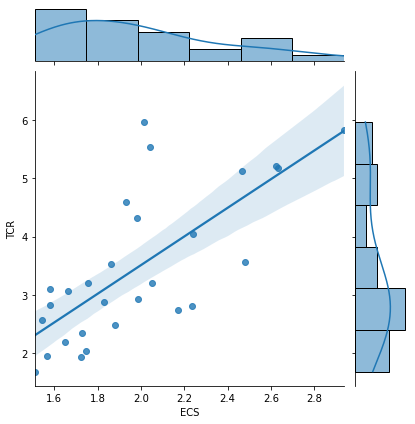

In [14]:
sn.jointplot(data=pd.concat([CMIP6_ECS,CMIP6_TCR],axis=1,keys=['TCR','ECS']),
            x='ECS',
            y='TCR',
            kind='reg')

# FaIR emulation verification runs

1pctCO2, abrupt-4xCO2, abrupt-2xCO2, abrupt-0p5xCO2 scenarios.

Starting from pre-industrial concentration of 284 in year 0.

In [15]:
## create the scenarios:
CMIP6_scenarios = pd.DataFrame(index=np.arange(250),columns=pd.MultiIndex.from_product([['1pctCO2','abrupt-4xCO2','abrupt-2xCO2','abrupt-0p5xCO2'],['carbon_dioxide']]))

CMIP6_scenarios['1pctCO2'] = 284*1.01**np.arange(1,251)
CMIP6_scenarios['abrupt-4xCO2'] = 284*4
CMIP6_scenarios['abrupt-2xCO2'] = 284*2
CMIP6_scenarios['abrupt-0p5xCO2'] = 284*0.5

CMIP6_scenarios.index.name='time'

In [16]:
CMIP6_scenarios.head()

,1pctCO2,abrupt-4xCO2,abrupt-2xCO2,abrupt-0p5xCO2
,carbon_dioxide,carbon_dioxide,carbon_dioxide,carbon_dioxide
time,,,,
0,286.840000,1136,568,142.0
1,289.708400,1136,568,142.0
2,292.605484,1136,568,142.0
3,295.531539,1136,568,142.0
4,298.486854,1136,568,142.0


In [17]:
## get gas parameter dataframe:
base_gas_params = get_gas_parameter_defaults()['default'].reindex(['carbon_dioxide'],axis=1)

In [18]:
## only relevant params are PI_conc & f parameters

CMIP6_gas_params = []

for model in CMIP6_F2x.index:
    model_gas_params = base_gas_params.copy()
    model_gas_params.loc['PI_conc','carbon_dioxide'] = 284
    model_gas_params.loc[['f1','f2','f3'],'carbon_dioxide'] = CMIP6_f_parameters[model]
    CMIP6_gas_params += [model_gas_params]
    
CMIP6_gas_params = pd.concat(CMIP6_gas_params,axis=1,keys=CMIP6_F2x.index).sort_index(axis=1).astype(float)

In [19]:
## do the emulations:

CMIP6_emulation = run_FaIR(concentrations_in=CMIP6_scenarios,
                          gas_parameters=CMIP6_gas_params,
                          thermal_parameters=CMIP6_IR_parameters.sort_index(axis=1)
                          )

Integrating 4 scenarios, 28 gas cycle parameter sets, 1 thermal response parameter sets, over ['carbon_dioxide'] forcing agents, between 0 and 249...


100%|██████████| 249/249 [00:00<00:00, 4083.75 timestep/s]


In [20]:
# prepare data for plotting:

CMIP6_emulation_tas_plot = pd.concat([
    CMIP6_emulation['T'].unstack().reset_index().rename({'Scenario':'scenario','Gas cycle set':'climate_model'},axis=1).set_index(['climate_model','scenario','time'])[0],
    CMIP6_input_data.mean('member_id').sel(climate_model=CMIP6_input_data.climate_model.isin(CMIP6_F2x.index)).stack(index=['climate_model','scenario']).tas.to_pandas().set_index(pd.Index(np.arange(250),name='time')).unstack()
          ],axis=0,keys=['FaIRv2.0.0-alpha','CMIP6']
).reset_index().rename({'level_0':'simulation',0:'tas'},axis=1)

## Save output for use elsewhere

In [21]:
# CMIP6_IR_parameters.to_csv('../../aux/parameter-sets/CMIP6_climresp.csv')

In [22]:
# CMIP6_f_parameters.to_csv('../../aux/parameter-sets/CMIP6_f_params.csv')

In [23]:
#definition to round to set sfs:
def round_to_sf(x,sf):
    if x==0:
        return 0
    if np.isnan(x):
        return '-'
    else:
        num= round(x, sf - int(np.floor(np.log10(abs(x)))))
        if abs(num)>10**sf:
            return str(int(num))
        else:
            return str(num)

In [30]:
# save to ltx table
IR_table = pd.concat([CMIP6_IR_parameters.stack().T,
                       CMIP6_f_parameters.T.sort_index(),
                       CMIP6_ECS.rename('ECS'),
                       CMIP6_TCR.rename('TCR'),
                       CMIP6_F2x.rename('F$_{2\times \text{CO}_2}$'),
                       CMIP6_EBM_parameters.loc['F_4x'].rename('F$_{4\times \text{CO}_2}$')],axis=1).rename({('d',1):'$d_1$',('d',2):'$d_2$',('d',3):'$d_3$',
                                                                                                             ('q',1):'$q_1$',('q',2):'$q_2$',('q',3):'$q_3$',
                                                                                                             'f1':'$f_1$','f2':'$f_2$','f3':'$f_3$'},axis=1).applymap(lambda x:round_to_sf(x,2))
IR_table.index.name = 'model'
IR_table.columns.name = 'parameter'
IR_table#.to_latex('../../docs/manuscript/tables/Tab2',escape=False,bold_rows=True)

# EBM_table = CMIP6_EBM_parameters.T.sort_index().drop(['gamma','stdx','stds'],axis=1).rename(dict(gamma='$\gamma$',C1='$C_1$',C2='$C_2$',C3='$C_3$',kap1='$\kappa_1$',kap2='$\kappa_2$',kap3='$\kappa_3$',epsilon='$\epsilon$',stds='$\sigma_\eta$',stdx='$\sigma_\chi$',F_4x='F$_{4\times \text{CO}_2}$'),axis=1).applymap(lambda x:round_to_sf(x,2))
# EBM_table.index.name = 'model'
# EBM_table.columns.name = 'parameter'
# EBM_table#.to_latex('../../docs/manuscript/tables/TabS5',escape=False,bold_rows=True)

parameter,$d_1$,$d_2$,$d_3$,$q_1$,$q_2$,$q_3$,$f_1$,$f_2$,$f_3$,ECS,TCR,F$_{2\times \text{CO}_2}$,F$_{4\times \text{CO}_2}$
model,,,,,,,,,,,,,
ACCESS-CM2,0.635,7.76,319,0.131,0.495,0.794,-0.799,0,0.515,4.32,1.98,3.04,7.58
ACCESS-ESM1-5,2.34,66.6,1040000000,0.445,0.426,2.45e-06,4.83,0,0.00086,2.92,1.99,3.35,6.71
AWI-CM-1-1-MR,1.09,6.29,163,0.203,0.306,0.335,4.3,0,0.117,3.2,2.05,3.79,7.93
BCC-CSM2-MR,0.976,5.78,208,0.192,0.23,0.402,0.821,0,0.408,2.82,1.58,3.42,8.02
BCC-ESM1,2.21,15.2,353,0.373,0.328,0.519,2.07,0,0.171,3.21,1.76,2.63,5.76
CAMS-CSM1-0,0.577,4.92,135,0.0991,0.284,0.154,6.26,0,0.00235,2.34,1.73,4.36,8.72
CESM2-FV2,0.531,4.37,417,0.0862,0.448,1.26,2.0,0,0.278,5.97,2.01,3.32,7.45
CESM2-WACCM,0.328,4.88,326,0.0516,0.482,0.864,0.0334,0,0.468,4.6,1.93,3.29,7.94
CESM2-WACCM-FV2,0.621,6.51,458,0.132,0.485,1.16,3.17,0,0.132,5.54,2.04,3.12,6.62


## Create plot for the paper

set some matplotlib rcParams

In [25]:
matplotlib.rcParams['font.family']='Helvetica'
matplotlib.rcParams['font.size']=11

matplotlib.rcParams['axes.formatter.limits']=-3,3

matplotlib.rcParams['legend.frameon']=False

plt.rcParams['pdf.fonttype'] = 42

/home/leachl/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.


''

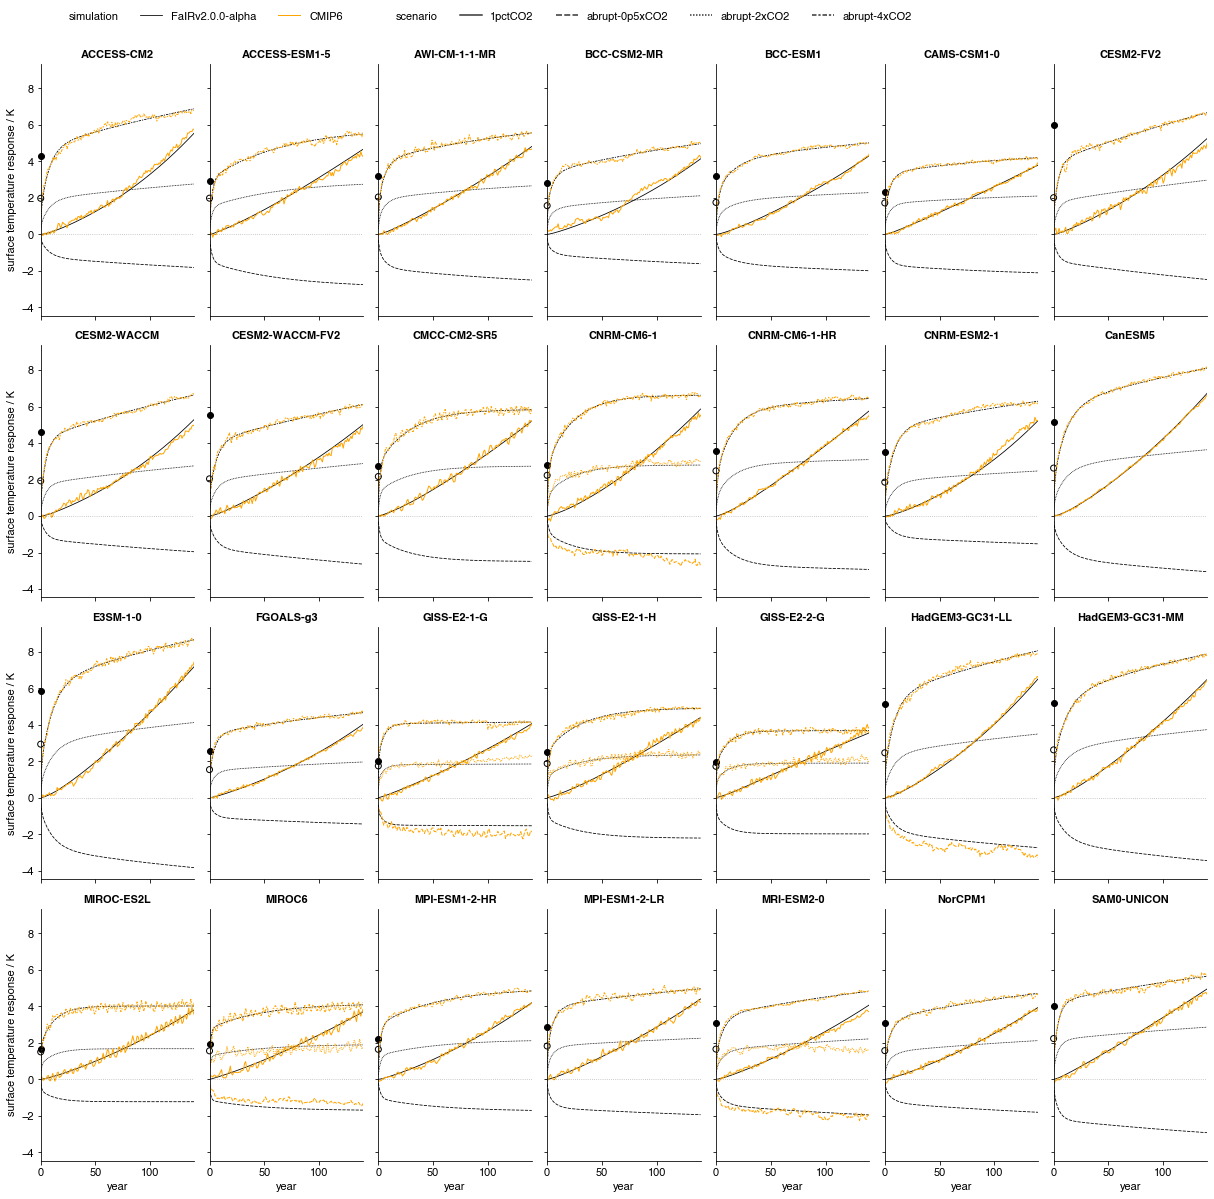

In [26]:
g = sn.relplot(data=CMIP6_emulation_tas_plot.loc[CMIP6_emulation_tas_plot.time<=140],
               x='time',
               y='tas',
               style='scenario',
               hue='simulation',
               col='climate_model',
               col_wrap=7,
               kind='line',
               size='simulation',
               sizes=[0.8,1],
               palette=['k','orange'],
               facet_kws={'margin_titles': True, 'legend_out': False},
               height=4,
               aspect=0.6)

# add in the climate responses
for i,model in enumerate(CMIP6_ECS.index):
    line=g.axes[i].scatter(0,CMIP6_ECS.loc[model],marker='o',color='k',zorder=-10)
    line.set_clip_on(False)
    line=g.axes[i].scatter(0,CMIP6_TCR.loc[model],marker='o',facecolor='',edgecolor='k',zorder=-10)
    line.set_clip_on(False)

g.map(plt.axhline,y=0,ls=':',alpha=0.3,color='k',lw=0.8)
g.set(xlim=[0,140],xlabel='year',ylabel='surface temperature response / K').set_titles(col_template="{col_name}",fontweight='bold')
g.axes[0].legend(loc=(0,0),bbox_to_anchor=(-0.05,1.15),ncol=8)

[g.fig.savefig('../../docs/manuscript/figures/Fig3.'+x,dpi=600,bbox_inches='tight') for x in ['png','pdf']]
''